# Product Analysis

- attempt to predict for customisation likelihood


In [52]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy

In [53]:
def find_classes(df):
    res_dict = {}
    for col in df.columns:
      try:
        res_dict[col+'_classes'] = [df[str(col)].unique()]
      except:
         print(f'Error with {col}')
         pass
    res_df = pd.DataFrame(data=res_dict)
    display(res_df)

In [54]:
data_path = 'survey_results.csv'
raw_df= pd.read_csv(data_path)

In [55]:
find_classes(raw_df)

,Which age group do you belong to?_classes,What is your gender?_classes,Which category do you currently belong to?_classes,Which of the following best describes you?_classes,Which of these factors are important to you when deciding which car to purchase?_classes,How likely are you to opt for customised vehicle if there were no extra charges? _classes,"Which of the following exterior components would you choose to customise (texture, layout, size, etc)? _classes","Which of the following interior components would you choose to customise (texture, layout, size, etc)? _classes",How much are you willing to spend on car customisation if surcharges are applicable?_classes,Are you interested in designing your own components to personalise your car? _classes,How much are you willing to pay for the personalised design? _classes,"Do you have any 3D design experience that would help with the design process? (e.g. AutoCAD, SolidWorks, Blender, etc)_classes",Please give us any design ideas to make the car uniquely Singaporean._classes
0,"[20-30, 51-60, 41-50, 31-40]","[Male, Female, Prefer not to say]","[Do not own a car, but planning to purchase in...","[Single, Married with children, Married with n...",[Price;Functionality;Size;Customisable options...,"[Very likely, Likely, Not likely]","[Grilles, Wheels;Grilles;Headlights;Side mirro...","[Centre compartment, Steering wheel;Dashboard,...","[100-500, under 500, 500-1000, over 1000, 0]","[Only with professional help, Yes, No]","[500-1000, under 500, over 1000, 0]","[No, I would need a designer to model my sketc...","[nan, wheels that look like the singapore flye..."


In [56]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 13 columns):
 #   Column                                                                                                                  Non-Null Count  Dtype 
---  ------                                                                                                                  --------------  ----- 
 0   Which age group do you belong to?                                                                                       50 non-null     object
 1   What is your gender?                                                                                                    50 non-null     object
 2   Which category do you currently belong to?                                                                              50 non-null     object
 3   Which of the following best describes you?                                                                              50 non-null     object
 4   Whic

## 1. Selection


In [57]:
target_df = raw_df.copy()

## 2. Fusing and Cleansing


In [58]:
preprocessed_df = target_df.copy()

In [59]:
def check_percentage(df, col, show = False):
  counts = df[col].value_counts()
  percentages = (counts / counts.sum()) * 100
  for index, value in percentages.items():
    if value < 5 or show:
        print('_'*80)
        print(col)
        print('_'*80)
        print(percentages)
        break

In [60]:
preprocessed_df.rename(columns={'Which age group do you belong to?': 'age_group', 
                            'What is your gender?': 'gender', 
                            "Which category do you currently belong to?": "car_ownership",
                            "Which of the following best describes you?": "maritial_status",
                            "Which of these factors are important to you when deciding which car to purchase?": "purchase_factors",
                            "How likely are you to opt for customised vehicle if there were no extra charges? ": "customise_likelihood",
                            "Which of the following exterior components would you choose to customise (texture, layout, size, etc)? ": "exterior_components",
                            "Which of the following interior components would you choose to customise (texture, layout, size, etc)? ": "interior_components",
                            "How much are you willing to spend on car customisation if surcharges are applicable?": "customise_spend",
                            "Are you interested in designing your own components to personalise your car? ": "personalise_interest",
                            "How much are you willing to pay for the personalised design? ": "personalise_spend",
                            "Do you have any 3D design experience that would help with the design process? (e.g. AutoCAD, SolidWorks, Blender, etc)": "design_experience",
                            "Please give us any design ideas to make the car uniquely Singaporean.": "design_ideas"
                            }, inplace=True)

In [61]:
preprocessed_df = preprocessed_df.dropna(subset=['exterior_components', 'purchase_factors'])
preprocessed_df.reset_index(drop=True, inplace=True)

In [62]:
preprocessed_df = preprocessed_df[preprocessed_df['gender'] != 'Prefer not to say']
preprocessed_df.reset_index(drop=True, inplace=True)

In [63]:
preprocessed_df['purchase_factors'] = preprocessed_df['purchase_factors'].str.split(';')
preprocessed_df['exterior_components'] = preprocessed_df['exterior_components'].str.split(';')
preprocessed_df['interior_components'] = preprocessed_df['interior_components'].str.split(';')

In [64]:
# for col in preprocessed_df.columns:
#   check_percentage(preprocessed_df, col)

In [65]:
# preprocessed_df = preprocessed_df[preprocessed_df['customise_likelihood'] != 'Not likely']
# preprocessed_df.reset_index(drop=True, inplace=True)

In [66]:
preprocessed_df['customise_spend'] = preprocessed_df.apply(lambda row: 'under 500' if row['customise_spend'] == '100-500' else row['customise_spend'], axis=1)
# preprocessed_df['customise_spend'] = preprocessed_df.apply(lambda row: 'under 500' if row['customise_spend'] == '0' else row['customise_spend'], axis=1)

In [67]:
# preprocessed_df['personalise_spend'] = preprocessed_df.apply(lambda row: 'under 500' if row['personalise_spend'] == '0' else row['personalise_spend'], axis=1)

In [68]:
preprocessed_df['car_ownership'] = preprocessed_df.apply(lambda row: 'None' if row['car_ownership'] == 'Do not own a car, but planning to purchase in future' else row['car_ownership'], axis=1)
preprocessed_df['car_ownership'] = preprocessed_df.apply(lambda row: 'One' if row['car_ownership'] == 'Own a car' else row['car_ownership'], axis=1)
preprocessed_df['car_ownership'] = preprocessed_df.apply(lambda row: 'More than One' if row['car_ownership'] == 'Own more than one car' else row['car_ownership'], axis=1)

In [69]:
preprocessed_df['design_experience'] = preprocessed_df.apply(lambda row: 1 if row['design_experience'] == 'Yes, I can design on my own' else 0, axis=1)

In [70]:
preprocessed_df['design_ideas'] = preprocessed_df['design_ideas'].str.lower()
preprocessed_df['design_ideas'] = preprocessed_df['design_ideas'].str.replace('[^\w\s]',' ')
preprocessed_df['design_ideas'] = preprocessed_df['design_ideas'].str.replace('\d+', '')
preprocessed_df['design_ideas'] = preprocessed_df['design_ideas'].str.replace('  ', ' ')
preprocessed_df['design_ideas'] = preprocessed_df['design_ideas'].str.strip()
preprocessed_df['design_ideas'] = preprocessed_df['design_ideas'].fillna('none')

In [71]:
# preprocessed_df.head()

## 3. Data Transformation


In [72]:
transformed_df = preprocessed_df.copy()

In [73]:
from sklearn.preprocessing import LabelEncoder

In [74]:
def expand_list_values(df, col):
    res_df = df.copy()
    dummy_df = pd.get_dummies(data=df[col].explode(), dtype=int, prefix=col, prefix_sep=':').groupby(level=0).sum()
    res_df = pd.concat([df, dummy_df], axis=1)
    # res_df = res_df.drop(columns=[col])
    return res_df
def expand_non_binary_values(df, col):
    res_df = df.copy()
    dummy_df = pd.get_dummies(data=df[col], dtype=int, prefix=col, prefix_sep=':').groupby(level=0).sum()
    res_df = pd.concat([df, dummy_df], axis=1)
    res_df = res_df.drop(columns=[col])
    return res_df
def encode_data_by_count(column_name, data_frame):
  print("_"*120)
  label_encoder = LabelEncoder()
  encoded_column_name = column_name+"_encoded"
  data_frame[encoded_column_name] = label_encoder.fit_transform(data_frame[column_name])
  legend = data_frame[[column_name, encoded_column_name]].copy()
  legend = legend.drop_duplicates().reset_index(drop=True)
  print(legend)
def encode_by_label(df, unique_values, col):
  print("_"*120)
  encoded_column_name = col+"_encoded"
  for i, val in enumerate(unique_values):
    if val not in df[col].unique():
      print(f"'{val}' not in {col}")
      return
  label_mapping = {val: i for i, val in enumerate(unique_values)}
  df[encoded_column_name] = df[col].map(label_mapping)
  legend = df[[col, encoded_column_name]].copy()
  legend = legend.drop_duplicates()
  legend = legend.sort_values(by=encoded_column_name)
  legend = legend.reset_index(drop=True)
  print(legend)

In [75]:
transformed_df=expand_list_values(transformed_df, 'purchase_factors')
transformed_df=expand_list_values(transformed_df, 'exterior_components')
transformed_df=expand_list_values(transformed_df, 'interior_components')

In [76]:
transformed_df['design_ideas'] = preprocessed_df.apply(lambda row: 0 if row['design_ideas'] == 'none' else 1, axis=1)

In [77]:
find_classes(transformed_df)

Error with purchase_factors
Error with exterior_components
Error with interior_components


,age_group_classes,gender_classes,car_ownership_classes,maritial_status_classes,customise_likelihood_classes,customise_spend_classes,personalise_interest_classes,personalise_spend_classes,design_experience_classes,design_ideas_classes,...,exterior_components:Side mirrors_classes,exterior_components:Wheels_classes,exterior_components:add body kit and change the exhaust and tune the engine_classes,exterior_components:doors_classes,interior_components:Centre compartment_classes,interior_components:Dashboard_classes,interior_components:Door handles_classes,interior_components:Steering wheel_classes,interior_components:Sun blocker for front passengers_classes,interior_components:air vent_classes
0,"[20-30, 51-60, 41-50, 31-40]","[Male, Female]","[None, More than One, One]","[Single, Married with children, Married with n...","[Very likely, Likely, Not likely]","[under 500, 500-1000, over 1000, 0]","[Only with professional help, Yes, No]","[500-1000, under 500, over 1000, 0]","[0, 1]","[0, 1]",...,"[0, 1]","[0, 1]","[0, 1]","[0, 1]","[1, 0]","[0, 1]","[0, 1]","[0, 1]","[0, 1]","[0, 1]"


In [78]:
encode_data_by_count('gender', transformed_df)
encode_data_by_count('maritial_status', transformed_df)

________________________________________________________________________________________________________________________
   gender  gender_encoded
0    Male               1
1  Female               0
________________________________________________________________________________________________________________________
            maritial_status  maritial_status_encoded
0                    Single                        2
1     Married with children                        0
2  Married with no children                        1


In [79]:
encode_by_label(transformed_df, ['0', 'under 500', '500-1000', 'over 1000'], 'customise_spend')
encode_by_label(transformed_df, ['0', 'under 500', '500-1000', 'over 1000'], 'personalise_spend')
encode_by_label(transformed_df, ['None', 'One', 'More than One'], 'car_ownership')
encode_by_label(transformed_df, ['Not likely', 'Likely', 'Very likely'], 'customise_likelihood')
encode_by_label(transformed_df, ['No', 'Only with professional help','Yes'], 'personalise_interest')
encode_by_label(transformed_df, ['20-30', '31-40', '41-50', '51-60'], 'age_group')

________________________________________________________________________________________________________________________
  customise_spend  customise_spend_encoded
0               0                        0
1       under 500                        1
2        500-1000                        2
3       over 1000                        3
________________________________________________________________________________________________________________________
  personalise_spend  personalise_spend_encoded
0                 0                          0
1         under 500                          1
2          500-1000                          2
3         over 1000                          3
________________________________________________________________________________________________________________________
   car_ownership  car_ownership_encoded
0           None                      0
1            One                      1
2  More than One                      2
___________________________

In [80]:
purchase_factors = transformed_df['purchase_factors'].explode().unique().tolist()
for i, val in enumerate(purchase_factors):
  purchase_factors[i] = 'purchase_factors:' + val
interior_components = transformed_df['interior_components'].explode().unique().tolist()
for i, val in enumerate(interior_components):
  interior_components[i] = 'interior_components:' + val
exterior_components = transformed_df['exterior_components'].explode().unique().tolist()
for i, val in enumerate(exterior_components):
  exterior_components[i] = 'exterior_components:' + val

In [81]:
transformed_df.head()

,age_group,gender,car_ownership,maritial_status,purchase_factors,customise_likelihood,exterior_components,interior_components,customise_spend,personalise_interest,...,interior_components:Sun blocker for front passengers,interior_components:air vent,gender_encoded,maritial_status_encoded,customise_spend_encoded,personalise_spend_encoded,car_ownership_encoded,customise_likelihood_encoded,personalise_interest_encoded,age_group_encoded
0,20-30,Male,None,Single,"[Price, Functionality, Size, Customisable opti...",Very likely,[Grilles],[Centre compartment],under 500,Only with professional help,...,0,0,1,2,1,2,0,2,1,0
1,20-30,Female,None,Single,"[Price, Brand name, Aesthetics, Technological ...",Likely,"[Wheels, Grilles, Headlights, Side mirrors]",[Centre compartment],under 500,Only with professional help,...,0,0,0,2,1,1,0,1,1,0
2,20-30,Male,None,Single,"[Aesthetics, Functionality, Customisable options]",Very likely,"[Wheels, Grilles, Headlights, Side mirrors]","[Steering wheel, Dashboard]",500-1000,Yes,...,0,0,1,2,2,2,0,2,2,0
3,20-30,Female,None,Single,"[Price, Brand name, Aesthetics, Technological ...",Very likely,"[Wheels, Grilles, Headlights, Side mirrors, Bu...","[Steering wheel, Centre compartment, Door hand...",under 500,Yes,...,0,0,0,2,1,1,0,2,2,0
4,20-30,Male,None,Single,"[Price, Brand name, Aesthetics, Technological ...",Very likely,"[Wheels, Grilles, Headlights, Bumpers]","[Steering wheel, Centre compartment]",over 1000,Only with professional help,...,0,0,1,2,3,3,0,2,1,0


## 4. Data Mining


In [82]:
data=transformed_df.copy()

In [83]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,roc_curve,roc_auc_score,confusion_matrix,classification_report

In [84]:
def model_evaluation(model, X_train, X_test, y_train, y_test, print_results=True):
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  if print_results:
    print(f"Model: {model.__class__.__name__}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"F1 Score: {f1_score(y_test, y_pred, average='weighted')}")
    print(f"Precision Score: \n{precision_score(y_test, y_pred, average='weighted')}")
    print(f"Recall Score: {recall_score(y_test, y_pred, average='weighted')}")
    print(f"Confusion Matrix: \n {confusion_matrix(y_test, y_pred)}")
    print(f"Classification Report: \n{classification_report(y_test, y_pred)}")
  # tp, fn, fp, tn = confusion_matrix(y_test,y_pred).reshape(-1)
  accuracy = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred, average='weighted')
  precision = precision_score(y_test, y_pred, average='weighted')
  recall = recall_score(y_test, y_pred, average='weighted')
  model_dict={'Model': [model.__class__.__name__], 'Accuracy': [round(accuracy,3)], 'F1_Score': [round(f1,3)], 'Precision': [round(precision,3)], 'Recall': [round(recall,3)]}
  try:
    model_df = pd.DataFrame(data=model_dict)
  except:
    print("Error creating model_df")
    print(model_dict)
    return
  return model, model_df

In [85]:
models = [LogisticRegression(), DecisionTreeClassifier(), RandomForestClassifier(), ExtraTreesClassifier(), KNeighborsClassifier(), GaussianNB()]

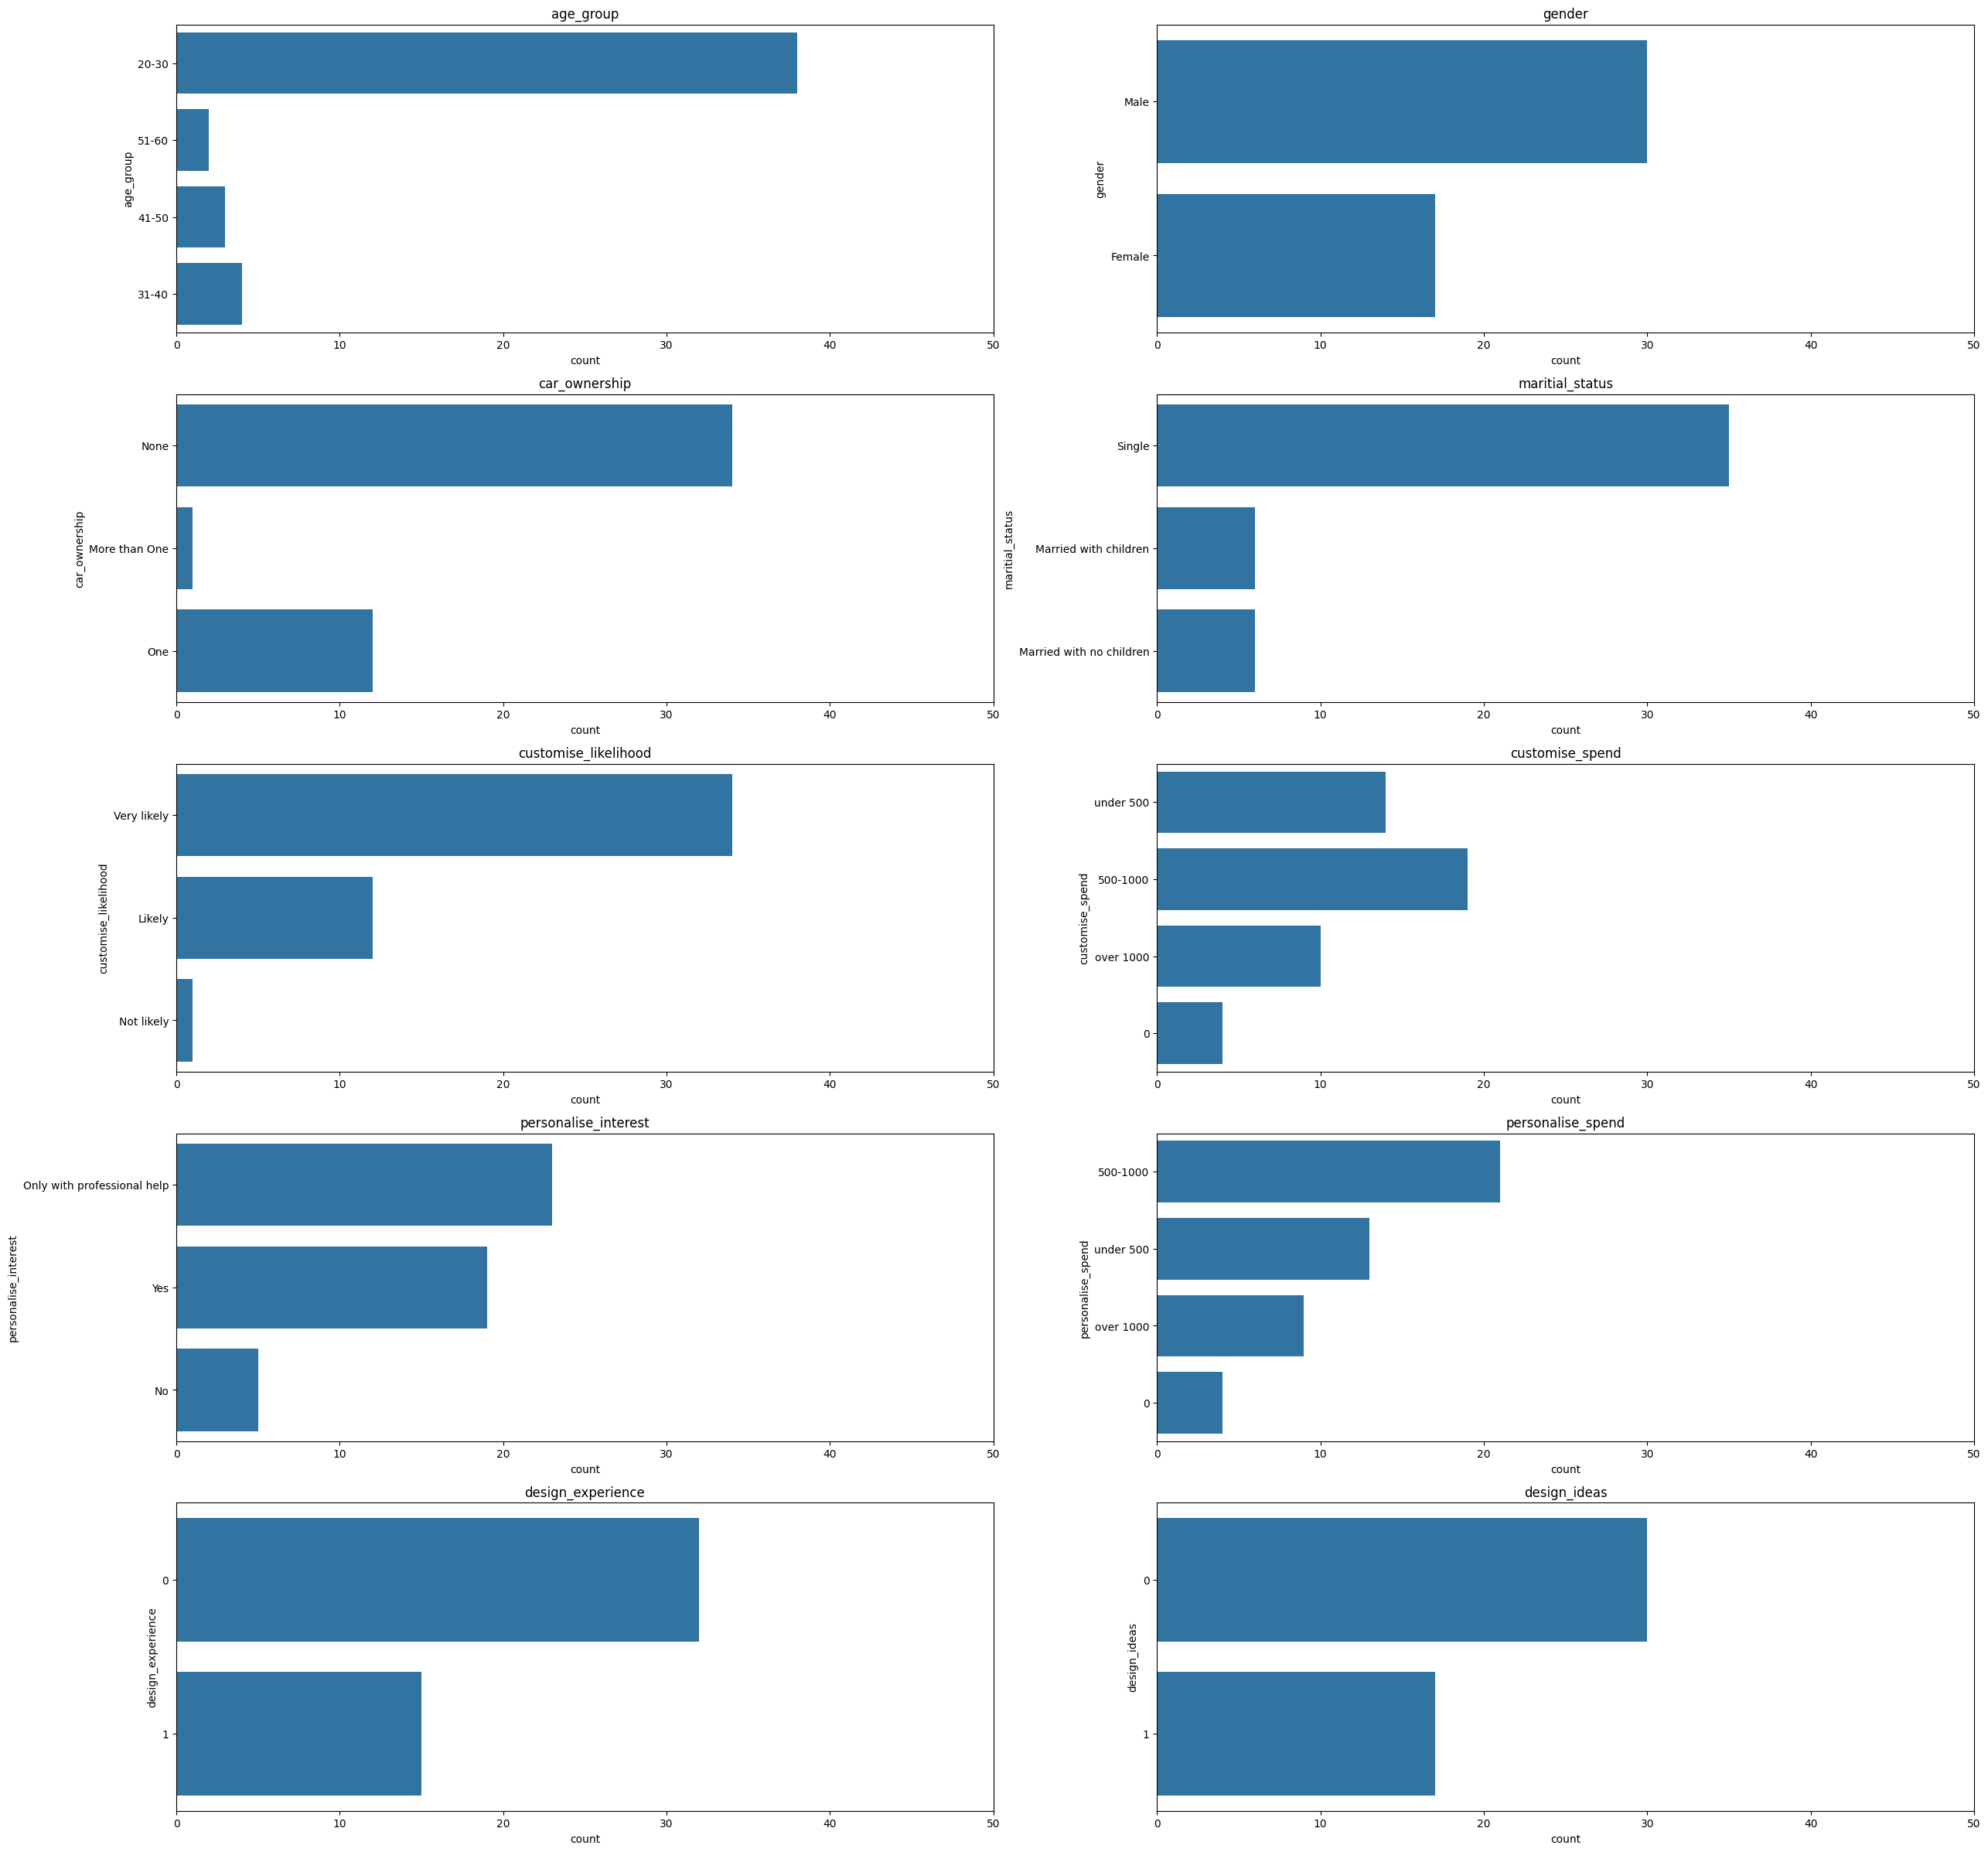

In [86]:
fig, ax = plt.subplots(figsize=(30, 30))
plt.axis('off')
select_columns = ['age_group', 'gender',
                  'car_ownership', 'maritial_status', 
                  'customise_likelihood', 'customise_spend', 
                  'personalise_interest', 'personalise_spend',
                  'design_experience', 'design_ideas']
for i, col in enumerate(select_columns):
  plt.subplot(5, 2, i+1)
  sns.countplot(data=data, y=col, orient='h')#, hue='customise_spend_encoded')
  plt.title(col)
  plt.xlim(0,50)
plt.show()

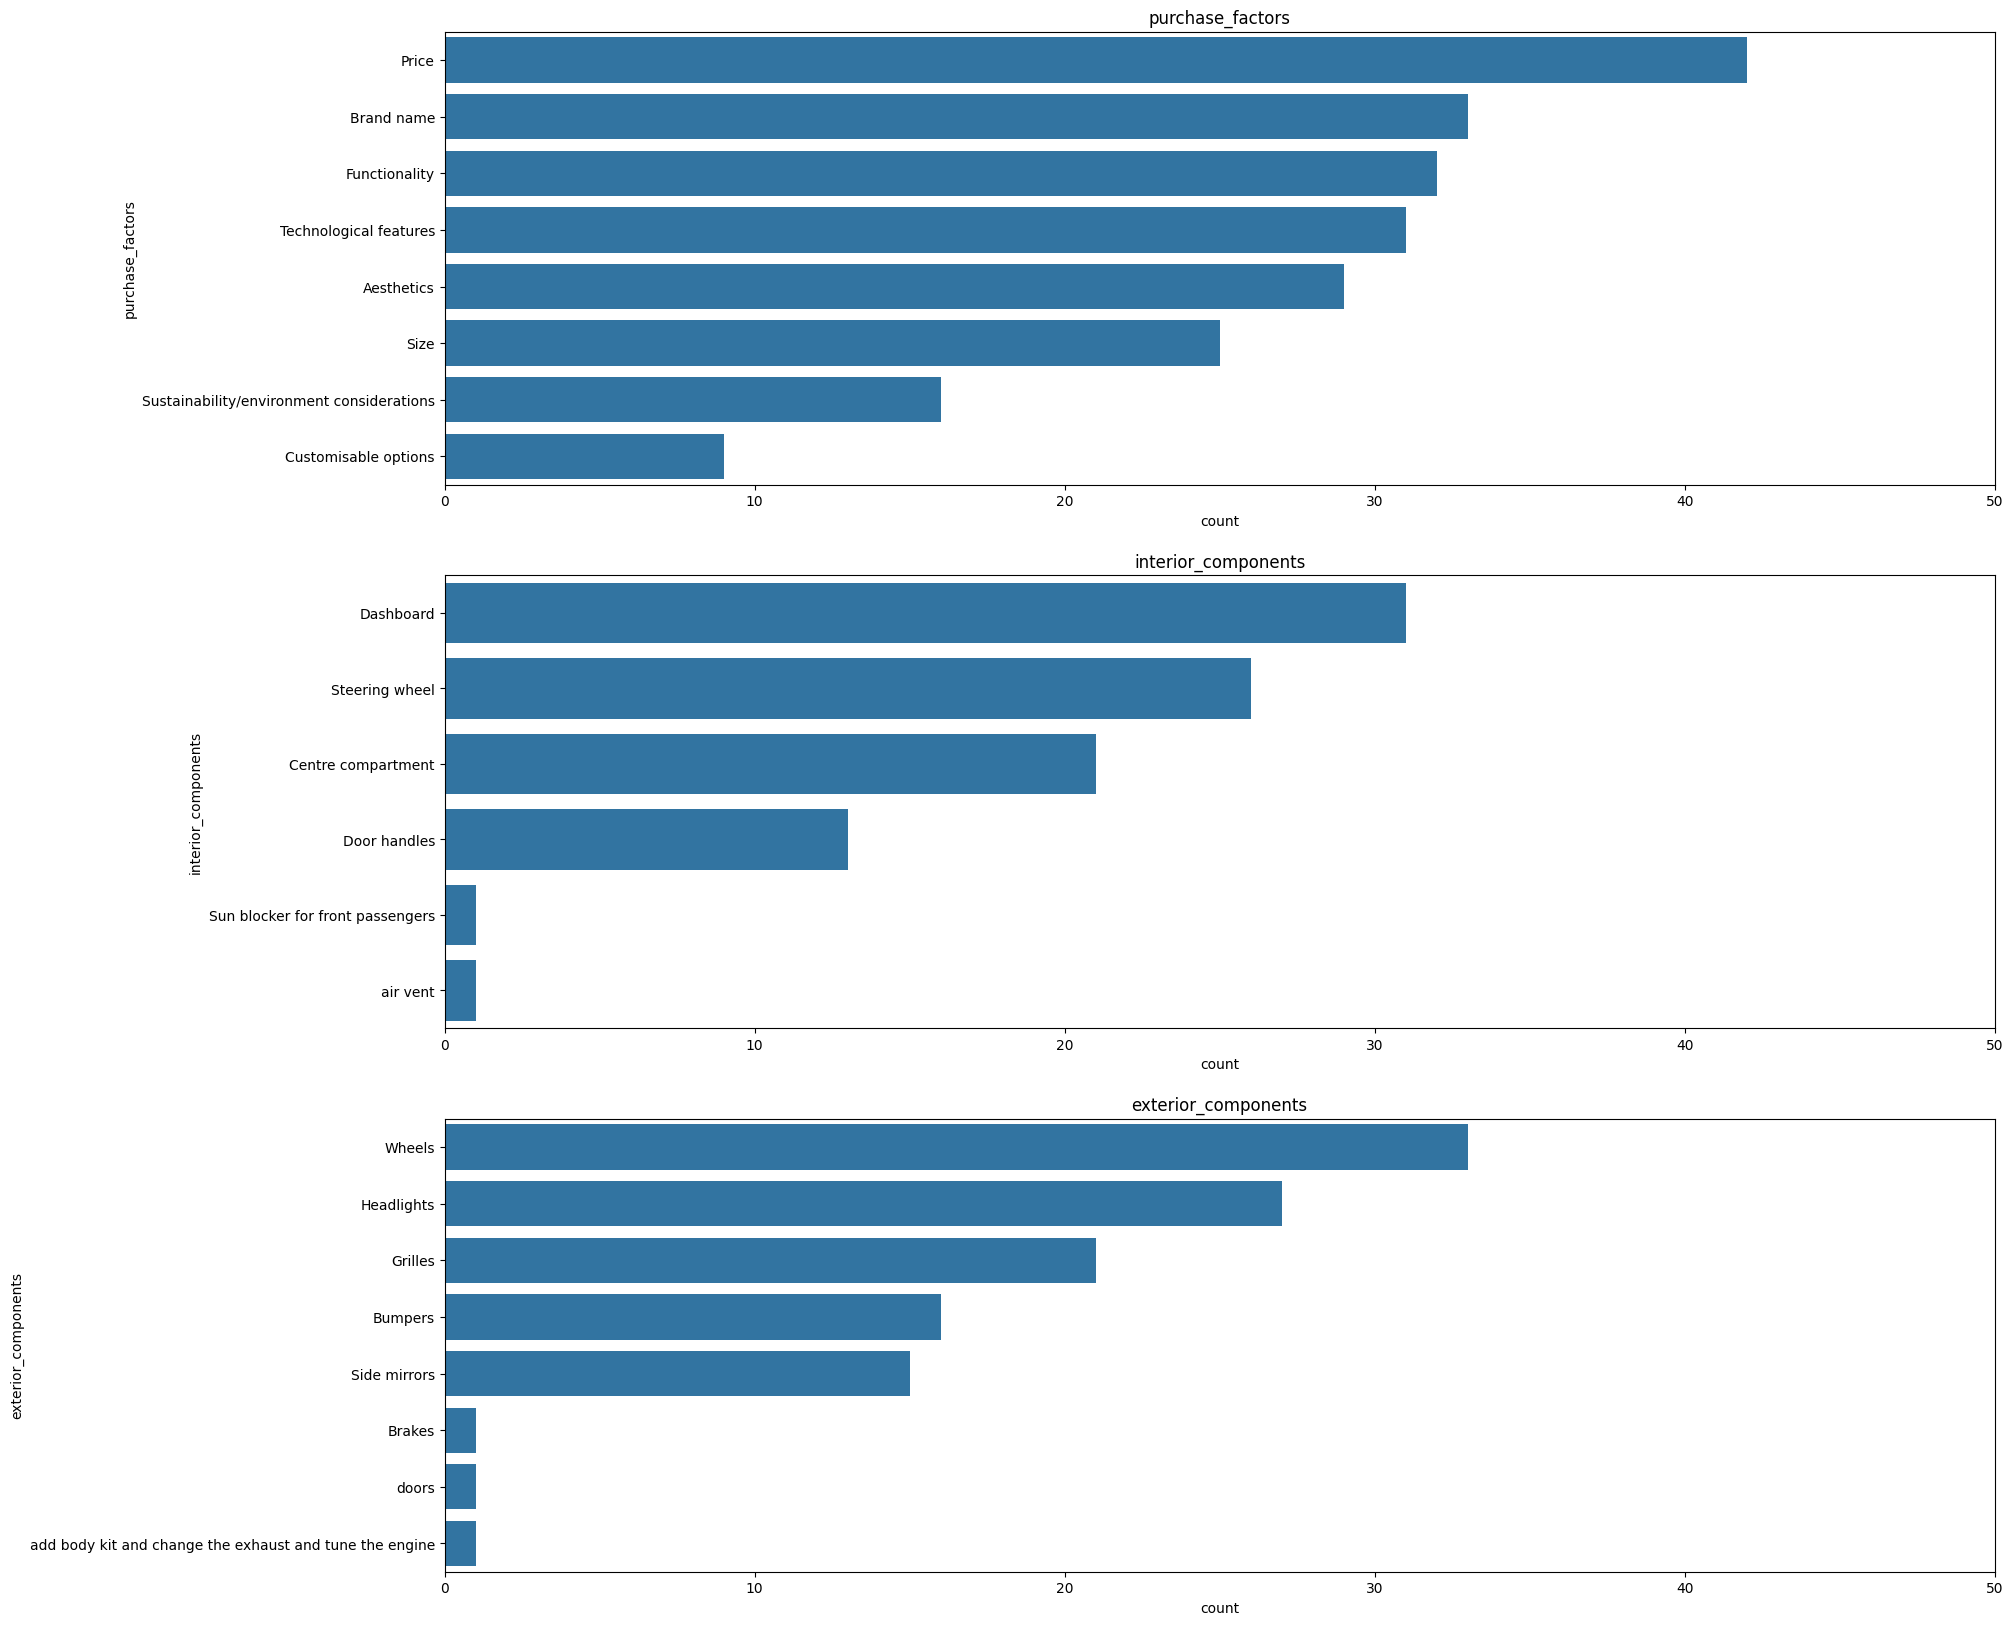

In [87]:
fig, ax = plt.subplots(figsize=(20, 20))
plt.axis('off')
select_columns = ['purchase_factors', 
                  'interior_components', 
                  'exterior_components']
for i, col in enumerate(select_columns):
  plt.subplot(3, 1, i+1)
  sns.barplot(data=data[col].explode().value_counts(),orient='h')
  plt.title(col)
  plt.xlim(0,50)
plt.show()

In [88]:
# fig, ax = plt.subplots(figsize=(20, 30))
# plt.axis('off')
# 
# for i, val in enumerate(purchase_factors):
#   purchase_factors[i] = 'purchase_factors:' + val
# deselect_columns = ['age_group', 'gender',
#                   'car_ownership', 'maritial_status', 
#                   'customise_likelihood', 'customise_spend', 
#                   'personalise_interest', 'personalise_spend',
#                   'design_experience', 'design_ideas', 
#                   'purchase_factors', 'interior_components', 
#                   'exterior_components', 'customise_spend_encoded']+purchase_factors
# count = 0
# for i, col in enumerate(data.columns):
#   if col in deselect_columns:
#     continue
#   plt.subplot(data.shape[1]-len(deselect_columns)//2, 2, count+1)
#   sns.countplot(data=data, y=col, orient='h', hue='customise_spend_encoded')
#   plt.title(col)
#   plt.xlim(0,30)
#   count += 1
# plt.show()

In [89]:
test_data = data.copy()
dropped_columns = [ 'age_group', 'gender',
                    'car_ownership', 'maritial_status', 
                    'customise_likelihood', 'customise_spend', 
                    'personalise_interest', 'personalise_spend',
                    'design_experience', 'design_ideas', 
                    'purchase_factors', 'interior_components', 
                    'exterior_components'
                    ]
test_data.drop(dropped_columns, axis=1, inplace=True)
corr = test_data.corr()
features_dict = {}
customise_features = []
for val in corr['customise_spend_encoded']:
  factor = 0.2
  if val > factor or val < -factor:
    features_dict[corr['customise_spend_encoded'][corr['customise_spend_encoded'] == val].index[0]] = [val]
    customise_features.append(corr['customise_spend_encoded'][corr['customise_spend_encoded'] == val].index[0])
display(pd.DataFrame(data=features_dict).transpose().rename(columns={0:'pearson_correlation to customise_spend'}).sort_values(by='pearson_correlation to customise_spend', ascending=False))

,pearson_correlation to customise_spend
customise_spend_encoded,1.000000
personalise_spend_encoded,0.722008
exterior_components:Wheels,0.337218
gender_encoded,0.332648
interior_components:Steering wheel,0.272192
purchase_factors:Price,-0.255056
exterior_components:Brakes,-0.290175


from the correlation matrix, we can conclude that there is a strong positive correlation between the amount one is willing to spend  
on a customisation and:

- exterior_components:Wheels
- gender_encoded
- interior_components:Steering wheel	
- purchase_factors:Sustainability/environment considerations

</br>
Therefore, you may increase these aspects to allow for more revenue

In [90]:
features_dict = {}
personalise_features = []
for val in corr['personalise_spend_encoded']:
  factor = 0.10
  if val > factor or val < -factor:
    features_dict[corr['personalise_spend_encoded'][corr['personalise_spend_encoded'] == val].index[0]] = [val]
    personalise_features.append(corr['personalise_spend_encoded'][corr['personalise_spend_encoded'] == val].index[0])
display(pd.DataFrame(data=features_dict).transpose().rename(columns={0:'pearson_correlation to personalise_spend'}).sort_values(by='pearson_correlation to personalise_spend', ascending=False))

,pearson_correlation to personalise_spend
personalise_spend_encoded,1.000000
customise_spend_encoded,0.722008
interior_components:Sun blocker for front passengers,0.214677
purchase_factors:Customisable options,0.206839
exterior_components:Grilles,0.166868
interior_components:Centre compartment,0.166868
interior_components:Dashboard,0.151807
gender_encoded,0.136596
interior_components:Door handles,0.127947
exterior_components:Side mirrors,-0.114893


In [91]:
modeled_data = data.copy()

for col in modeled_data.columns:
  if col not in customise_features:
    if col == 'customise_spend_encoded':
      continue
    modeled_data.drop(col, axis=1, inplace=True)
modeled_data.drop('personalise_spend_encoded', axis=1, inplace=True)
# modeled_data.drop('customise_likelihood_encoded', axis=1, inplace=True)
# modeled_data.drop('personalise_interest_encoded', axis=1, inplace=True)
    
y = modeled_data['customise_spend_encoded']
X = modeled_data.drop(['customise_spend_encoded'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape
res = pd.DataFrame(columns=['Model', 'Accuracy', 'F1_Score', 'Precision', 'Recall'])
customised_vehicle_likelihood_model = {}
for model in models:
  model_res, model_df = model_evaluation(model, X_train, X_test, y_train, y_test, False)
  res = pd.concat([res, model_df], ignore_index=True)
  customised_vehicle_likelihood_model[model.__class__.__name__] = model_res
  del model_res
  del model_df
res = res.sort_values(by='Accuracy', ascending=False)
res = res.reset_index(drop=True)
display(res)

/Users/bentjh01/Documents/01_NTU/Sem_8/temp/MA4829_Machine_Intelligence/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/var/folders/bt/pg056kkx3wx3rkfyhvzh2lwh0000gn/T/ipykernel_87429/3486009284.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  res = pd.concat([res, model_df], ignore_index=True)
/Users/bentjh01/Documents/01_NTU/Sem_8/temp/MA4829_Machine_Intelligence/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is il

,Model,Accuracy,F1_Score,Precision,Recall
0,KNeighborsClassifier,0.533,0.449,0.440,0.533
1,GaussianNB,0.467,0.333,0.267,0.467
2,ExtraTreesClassifier,0.400,0.385,0.383,0.400
3,LogisticRegression,0.333,0.175,0.119,0.333
4,DecisionTreeClassifier,0.333,0.339,0.351,0.333
5,RandomForestClassifier,0.200,0.143,0.111,0.200


In [92]:
# modeled_data = data.copy()
# purchase_factors = data['purchase_factors'].explode().unique().tolist()
# for i, val in enumerate(purchase_factors):
#   purchase_factors[i] = 'purchase_factors:' + val
# interior_components = data['interior_components'].explode().unique().tolist()
# for i, val in enumerate(interior_components):
#   interior_components[i] = 'interior_components:' + val
# exterior_components = data['exterior_components'].explode().unique().tolist()
# for i, val in enumerate(exterior_components):
#   exterior_components[i] = 'exterior_components:' + val
# dropped_columns = [ 'age_group', 'gender',
#                     'car_ownership', 'maritial_status', 
#                     'customise_likelihood', 'customise_spend_encoded', 
#                     'personalise_interest', 'personalise_spend',
#                     'design_experience', 'design_ideas', 
#                     'purchase_factors', 'interior_components', 
#                     'exterior_components', 'personalise_spend_encoded'
#                     ]+purchase_factors+interior_components+exterior_components
# modeled_data.drop(dropped_columns, axis=1, inplace=True)
# y = modeled_data['customise_spend']
# X = modeled_data.drop(['customise_spend'], axis=1)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# X_train.shape,X_test.shape,y_train.shape,y_test.shape
# res = pd.DataFrame(columns=['Model', 'Accuracy', 'F1_Score', 'Precision', 'Recall'])
# customised_vehicle_likelihood_model = {}
# for model in models:
#   model_res, model_df = model_evaluation(model, X_train, X_test, y_train, y_test, False)
#   res = pd.concat([res, model_df], ignore_index=True)
#   customised_vehicle_likelihood_model[model.__class__.__name__] = model_res
#   del model_res
#   del model_df
# res = res.sort_values(by='Accuracy', ascending=False)
# res = res.reset_index(drop=True)
# display(res)

In [93]:
from sklearn.decomposition import PCA, KernelPCA
modeled_data = data.copy()

for col in modeled_data.columns:
  if col not in customise_features:
    if col == 'customise_spend_encoded':
      continue
    modeled_data.drop(col, axis=1, inplace=True)
modeled_data.drop('personalise_spend_encoded', axis=1, inplace=True)
# modeled_data.drop('customise_likelihood_encoded', axis=1, inplace=True)
# modeled_data.drop('personalise_interest_encoded', axis=1, inplace=True)

y = modeled_data['customise_spend_encoded']
X = modeled_data.drop(['customise_spend_encoded'], axis=1)

# X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
pca = PCA()
new_df = pca.fit_transform(X)
# print(X_r.explained_variance_ratio_)
# print(X_r.singular_values_)
# print(X_r.components_)
new_df.shape

(47, 5)

In [94]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(new_df)

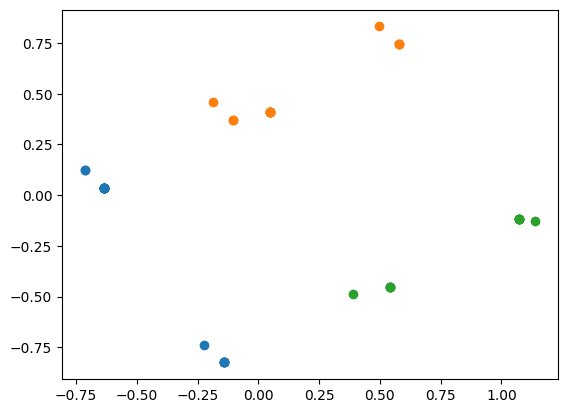

In [95]:
import matplotlib.pyplot as plt
 
#filter rows of original data
filtered_label0 = new_df[clusters == 0]
filtered_label1 = new_df[clusters == 1]
filtered_label2 = new_df[clusters == 2]
 
#plotting the results
plt.scatter(filtered_label0[:,0] , filtered_label0[:,1])
plt.scatter(filtered_label1[:,0] , filtered_label1[:,1])
plt.scatter(filtered_label2[:,0] , filtered_label2[:,1])
plt.show()

In [96]:
modeled_data = new_df.copy()
    
y = data['customise_spend_encoded']
X = modeled_data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape
res = pd.DataFrame(columns=['Model', 'Accuracy', 'F1_Score', 'Precision', 'Recall'])
customised_vehicle_likelihood_model = {}
for model in models:
  model_res, model_df = model_evaluation(model, X_train, X_test, y_train, y_test, False)
  res = pd.concat([res, model_df], ignore_index=True)
  customised_vehicle_likelihood_model[model.__class__.__name__] = model_res
  del model_res
  del model_df
res = res.sort_values(by='Accuracy', ascending=False)
res = res.reset_index(drop=True)
display(res)

/Users/bentjh01/Documents/01_NTU/Sem_8/temp/MA4829_Machine_Intelligence/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/var/folders/bt/pg056kkx3wx3rkfyhvzh2lwh0000gn/T/ipykernel_87429/4187301072.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  res = pd.concat([res, model_df], ignore_index=True)
/Users/bentjh01/Documents/01_NTU/Sem_8/temp/MA4829_Machine_Intelligence/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is il

,Model,Accuracy,F1_Score,Precision,Recall
0,DecisionTreeClassifier,0.467,0.409,0.388,0.467
1,ExtraTreesClassifier,0.400,0.385,0.383,0.400
2,KNeighborsClassifier,0.400,0.380,0.400,0.400
3,LogisticRegression,0.333,0.175,0.119,0.333
4,RandomForestClassifier,0.267,0.223,0.211,0.267
5,GaussianNB,0.267,0.263,0.283,0.267


In [97]:
from arulespy.arules import Transactions, apriori, parameters, concat

In [98]:
purchase_factors_df = data.loc[:, purchase_factors]
for col in purchase_factors_df.columns:
  purchase_factors_df[col] = purchase_factors_df.apply(lambda row: True if row[col] == 1 else False, axis=1)

trans = Transactions.from_df(purchase_factors_df)

rules = apriori(trans,
                    parameter = parameters({"supp": 0.1, "conf": 0.8}), 
                    control = parameters({"verbose": False}))  
rules_df = rules.as_df()
rules_df = rules_df.sort_values(by='lift', ascending=False)
rules_df.to_csv('purchase_factors_rules.csv')
display(rules_df)

,LHS,RHS,support,confidence,coverage,lift,count
63,"{purchase_factors:Price,purchase_factors:Custo...",{purchase_factors:Sustainability/environment c...,0.106383,0.833333,0.127660,2.447917,5
66,"{purchase_factors:Price,purchase_factors:Funct...",{purchase_factors:Size},0.106383,0.833333,0.127660,1.566667,5
68,"{purchase_factors:Price,purchase_factors:Custo...",{purchase_factors:Technological features},0.106383,1.000000,0.106383,1.516129,5
72,"{purchase_factors:Functionality,purchase_facto...",{purchase_factors:Technological features},0.106383,1.000000,0.106383,1.516129,5
12,"{purchase_factors:Customisable options,purchas...",{purchase_factors:Technological features},0.106383,1.000000,0.106383,1.516129,5
...,...,...,...,...,...,...,...
10,{purchase_factors:Functionality},{purchase_factors:Price},0.595745,0.875000,0.680851,0.979167,28
3,{purchase_factors:Sustainability/environment c...,{purchase_factors:Price},0.297872,0.875000,0.340426,0.979167,14
21,"{purchase_factors:Customisable options,purchas...",{purchase_factors:Price},0.127660,0.857143,0.148936,0.959184,6
73,"{purchase_factors:Functionality,purchase_facto...",{purchase_factors:Price},0.106383,0.833333,0.127660,0.932540,5


In [99]:
exterior_components_df = data.loc[:, exterior_components]
for col in exterior_components_df.columns:
  exterior_components_df[col] = exterior_components_df.apply(lambda row: True if row[col] == 1 else False, axis=1)

trans = Transactions.from_df(exterior_components_df)

rules = apriori(trans,
                    parameter = parameters({"supp": 0.1, "conf": 0.8}), 
                    control = parameters({"verbose": False}))  
rules_df = rules.as_df()
rules_df = rules_df.sort_values(by='lift', ascending=False)
rules_df.to_csv('exterior_components_rules.csv')
display(rules_df)

,LHS,RHS,support,confidence,coverage,lift,count
4,"{exterior_components:Side mirrors,exterior_com...",{exterior_components:Grilles},0.106383,1.000000,0.106383,2.238095,5
6,"{exterior_components:Grilles,exterior_componen...",{exterior_components:Headlights},0.148936,0.875000,0.170213,1.523148,7
9,"{exterior_components:Grilles,exterior_componen...",{exterior_components:Headlights},0.234043,0.846154,0.276596,1.472934,11
8,"{exterior_components:Wheels,exterior_component...",{exterior_components:Headlights},0.212766,0.833333,0.255319,1.450617,10
10,"{exterior_components:Grilles,exterior_componen...",{exterior_components:Headlights},0.106383,0.833333,0.127660,1.450617,5
1,{exterior_components:Side mirrors},{exterior_components:Headlights},0.255319,0.800000,0.319149,1.392593,12
5,"{exterior_components:Headlights,exterior_compo...",{exterior_components:Wheels},0.148936,0.875000,0.170213,1.246212,7
7,"{exterior_components:Headlights,exterior_compo...",{exterior_components:Wheels},0.212766,0.833333,0.255319,1.186869,10
3,{exterior_components:Headlights},{exterior_components:Wheels},0.468085,0.814815,0.574468,1.160494,22
2,{exterior_components:Side mirrors},{exterior_components:Wheels},0.255319,0.800000,0.319149,1.139394,12


In [100]:
interior_components_df = data.loc[:, interior_components]
for col in interior_components_df.columns:
  interior_components_df[col] = interior_components_df.apply(lambda row: True if row[col] == 1 else False, axis=1)

trans = Transactions.from_df(interior_components_df)

rules = apriori(trans,
                    parameter = parameters({"supp": 0.1, "conf": 0.8}), 
                    control = parameters({"verbose": False}))  
rules_df = rules.as_df()
rules_df = rules_df.sort_values(by='lift', ascending=False)
rules_df.to_csv('interior_components_rules.csv')
display(rules_df)

,LHS,RHS,support,confidence,coverage,lift,count
1,"{interior_components:Dashboard,interior_compon...",{interior_components:Steering wheel},0.12766,0.857143,0.148936,1.549451,6


In [105]:
arules_df = data.copy()
select_columns = ['customise_spend_encoded']+interior_components+exterior_components
for col in arules_df.columns:
  if col not in select_columns:
    arules_df.drop(col, axis=1, inplace=True)

trans = Transactions.from_df(arules_df)

rules = apriori(trans,
                    parameter = parameters({"supp": 0.1, "conf": 0.8}), 
                    control = parameters({"verbose": False}))  
rules_df = rules.sort(by = 'lift').as_df()
customise_spend_df = rules_df.loc[rules_df['RHS'] == '{customise_spend_encoded=[2,3]}']
customise_spend_df.to_csv('customise_spend_rules.csv')
display(customise_spend_df)

R[write to console]: In addition: 
R[write to console]: There were 15 warnings (use warnings() to see them)
R[write to console]: 



,LHS,RHS,support,confidence,coverage,lift,count


In [109]:
arules_df.shape

(47, 15)

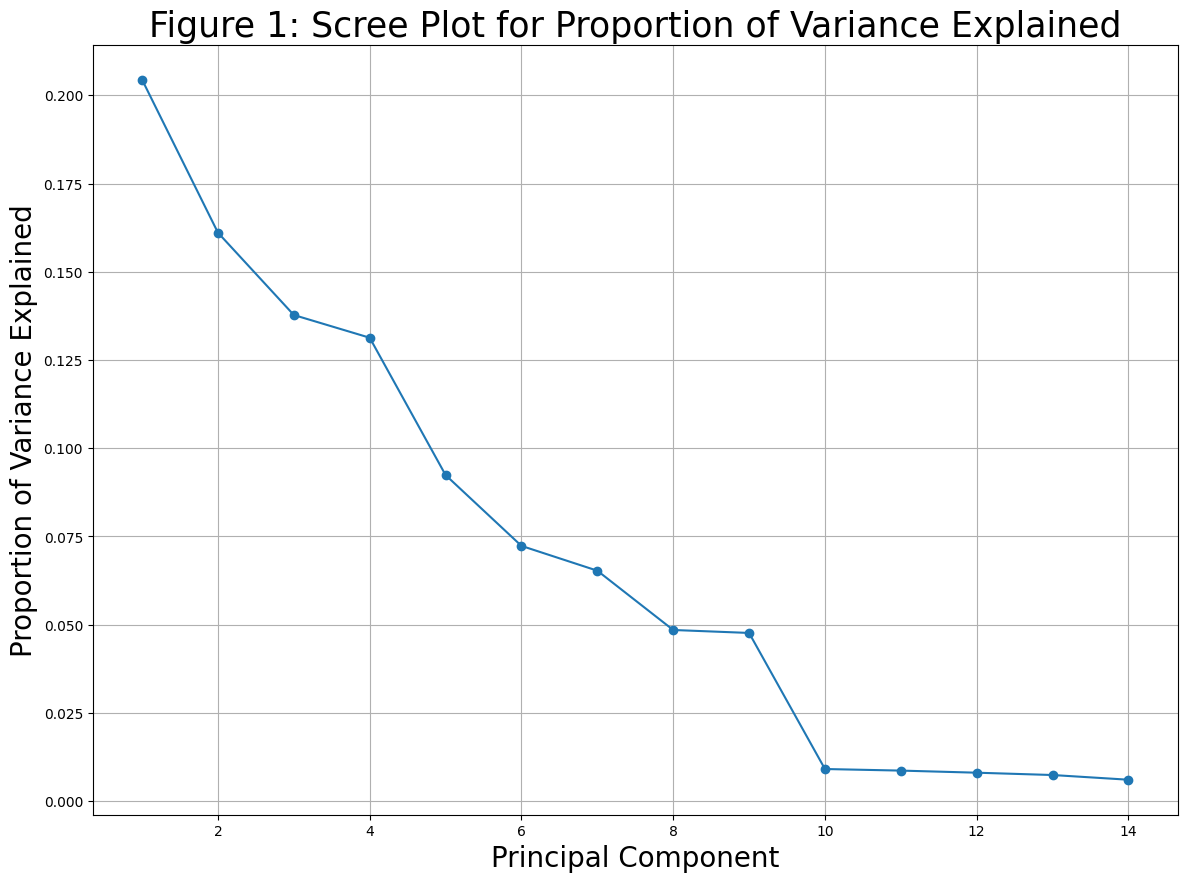

In [129]:
df = arules_df.copy()
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
df = pd.DataFrame(data = scaler.fit_transform(df), columns = df.columns)

pca = PCA()
pca.fit(df.drop('customise_spend_encoded', axis=1))

eigenvalues = pca.explained_variance_
prop_var = eigenvalues / np.sum(eigenvalues)

plt.figure(figsize=(14,10))
plt.plot(np.arange(1, len(prop_var)+1), 
                   prop_var, marker='o')
plt.xlabel('Principal Component',
           size = 20)
plt.ylabel('Proportion of Variance Explained',
           size = 20)
plt.title('Figure 1: Scree Plot for Proportion of Variance Explained',
          size = 25)
plt.grid(True)

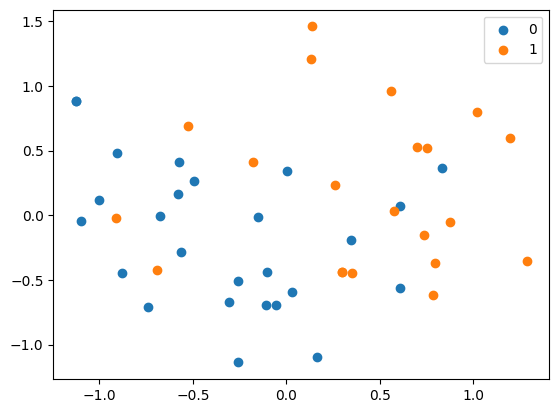

/Users/bentjh01/Documents/01_NTU/Sem_8/temp/MA4829_Machine_Intelligence/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/var/folders/bt/pg056kkx3wx3rkfyhvzh2lwh0000gn/T/ipykernel_87429/2656389222.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  res = pd.concat([res, model_df], ignore_index=True)
/Users/bentjh01/Documents/01_NTU/Sem_8/temp/MA4829_Machine_Intelligence/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is il

,Model,Accuracy,F1_Score,Precision,Recall
0,DecisionTreeClassifier,0.400,0.350,0.348,0.400
1,KNeighborsClassifier,0.333,0.246,0.244,0.333
2,RandomForestClassifier,0.267,0.214,0.224,0.267
3,ExtraTreesClassifier,0.267,0.214,0.224,0.267
4,LogisticRegression,0.200,0.111,0.077,0.200
5,GaussianNB,0.133,0.083,0.061,0.133


In [133]:
X = PCA(n_components=10).fit_transform(arules_df.drop('customise_spend_encoded', axis=1))
y = arules_df['customise_spend_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X)

#filter rows of original data
filtered_label0 = X[clusters == 0]
filtered_label1 = X[clusters == 1]
# filtered_label2 = X[clusters == 2]
 
u_labels = np.unique(clusters)
 
#plotting the results:
 
for i in u_labels:
    plt.scatter(X[clusters == i , 0] , X[clusters == i , 1] , label = i)
plt.legend()
plt.show()

res = pd.DataFrame(columns=['Model', 'Accuracy', 'F1_Score', 'Precision', 'Recall'])
customised_vehicle_likelihood_model = {}
for model in models:
  model_res, model_df = model_evaluation(model, X_train, X_test, y_train, y_test, False)
  res = pd.concat([res, model_df], ignore_index=True)
  customised_vehicle_likelihood_model[model.__class__.__name__] = model_res
  del model_res
  del model_df
res = res.sort_values(by='Accuracy', ascending=False)
res = res.reset_index(drop=True)
display(res)
